# Bayes Networks

## Install required packages

In [1]:
#They take a while to install

#Uncomment if you are using colab
#!apt install libgraphviz-dev 

!pip3 install pomegranate --quiet
#!pip3 install pygraphviz  --quiet
!pip3 install pandas 
!pip3 install matplotlib


  ERROR: Command errored out with exit status 1:
   command: /home/thierens/anaconda3/envs/AIPractical2/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0e4oc53i/pomegranate/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0e4oc53i/pomegranate/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-0chqd1wv
       cwd: /tmp/pip-install-0e4oc53i/pomegranate/
  Complete output (456 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/io.py -> build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/callbacks.py -> build/lib.linux-x86_64-3.8/pomegranate
  copying pomegranate/__init__.py -> build/lib.linux-x86_64-3.8/pomegranate
  creating build/lib.linux-x86_64-3.

In [9]:
!pip3 install pandas 
!pip3 install matplotlib

## Libraries

In [78]:
from pomegranate import BayesianNetwork, DiscreteDistribution, Node, ConditionalProbabilityTable
from matplotlib.pyplot import figure
import pandas as pd
# Cosmetics
%config InlineBackend.figure_format ='retina'
pd.options.display.float_format = '{:,.3f}'.format
def print_df(array):
    print(pd.DataFrame(array).to_string(header=False,index = False))
    

## Helper Functions
We integrate the functionalities of the library with code below. 

In [79]:
#@title 

# Updates and plot the model and infers the conditional probability
def add_conditional_variable(variable_name,statistics,ordered_conditionals,
                             ordered_parents,distributions,nodes,model,plot=True):
    kopy = ordered_conditionals.copy()
    if variable_name not in distributions.keys():
        distribution = ConditionalProbabilityTable(
            explicit_probabilities(ordered_conditionals.copy()[variable_name]),
            [distributions[parent] for parent in ordered_parents[variable_name]]
            )
        distributions[variable_name] = distribution 
        node = Node(distribution, variable_name)
        nodes[variable_name] = node
        model.add_states(node)
        for parent in ordered_parents[variable_name]:
            model.add_edge(nodes[parent], node)   
    if plot:
        figure(dpi=160) 
        model.plot()
    model.bake()
    # Inferred probability of 'Y'
    inferred_probability = model.marginal()[-1].parameters[0]['Y']
    print(f'{variable_name}: \n\t Inferred probability = {inferred_probability:.3f}') 
    print( f'\t Statistic = {statistics[variable_name]}')
    assert kopy == ordered_conditionals

# Needed to explicitly state probabilities for Y and N
def explicit_probabilities(array):
    new_array = []
    for row in array:
        Y_row = row.copy()
        N_row = row.copy()
        Y_row.insert(-1, 'Y'),
        N_row.insert(-1, 'N'),
        N_row[-1] = 1 - row[-1]
        new_array.extend([Y_row,N_row])
    return new_array

# Helper function to increase readability
def print_predict_proba(model, nodes, obs_states, target=None):
    distrs = model.predict_proba([obs_states])[0]
    evidence = []
    uknown_distrs = []
    uknown_variables = []
    for name, state, distr in zip(nodes.keys(),obs_states,distrs):
        if state == 'Y':
            evidence.append(name)
        elif state == 'N':
            evidence.append('No_'+name)
        else:
            uknown_distrs.append(distr)
            uknown_variables.append(name)
    # We recapitulate the evidence and print the probabilities
    print(f'When C = {", ".join(evidence)}:')
    for name, distr in zip(uknown_variables,uknown_distrs):
        if not target or target == name:
            print(f'Prob({name}|C): {distr.parameters[0]["Y"]:.3f}')
    print()


## Inserting data from the medical report

In [80]:
# Fill in the following dictionary with the names of variables (keys) and their probabilities (values).
# Only two states per variable ('Y' and 'N'), shown probabilities for 'Y'.
# Variables with unknown statistic should be listed with value None
statistics = {'Weakened_immune': .053,
              'Smoking': .29,
               'Pneumonia': .018,
                'Lung cancer': .037,
                 'Bronchitis': 0.09,
                    'Common cold': .37,
                     'Fever': .085,
                        'Loose cough': .19,
                            'Chest pain': .14,
                                'Shortness of breath': .18,
                                    'Runny nose': None}
                                    

# Update the following dictionary with the name of their dependecies to express the 
# Topology as a list of parent nodes
ordered_parents = {variable: [] for variable in statistics.keys()}
ordered_parents.update({'Shortness of breath': ['Bronchitis', 'Lung cancer', 'Pneumonia'], 'Chest pain': ['Lung cancer', 'Pneumonia'],
                        'Fever':['Pneumonia','Common cold'], 'Runny nose':['Common cold'], 'Loose cough':['Bronchitis','Pneumonia'], 'Lung cancer':['Smoking'],
                       'Bronchitis':['Smoking'], 'Pneumonia':['Weakened_immune', 'Lung cancer']})

# Fill in the following CPT table with the states of the ordered parents ('N','Y', None if not known)
# corresponding to the event P(X='Y'|parents(X)). The probabilies P(X='N'|parents(X)) 
# will be automatically calculated later on.
ordered_conditionals = { 'Shortness of breath': [['Y', 'Y', 'Y', .8],
                                                 ['Y', 'Y', 'N', .8],
                                                 ['Y', 'N', 'Y', .8],
                                                 ['Y', 'N', 'N', .8],
                                                 ['N', 'Y', 'Y', .5],
                                                 ['N', 'N', 'Y', .5],
                                                 ['N', 'Y', 'N', .5],
                                                 ['N', 'N', 'N', .1]],
                        'Chest pain':[['Y', 'Y', .9],
                                      ['Y', 'N', .9],
                                      ['N', 'Y', .9],
                                      ['N', 'N', .1]],
                        'Loose cough':[['Y', 'Y', .9],
                                      ['Y', 'N', .9],
                                      ['N', 'Y', .9],
                                      ['N', 'N', .1]],
                        'Fever':[['N', 'Y', .2],
                                 ['Y', 'N', .94],
                                 ['Y', 'Y', .952],
                                 ['N', 'N', .001]],
                        'Runny nose':[['Y', .95],
                                      ['N', .01]],
                        'Lung cancer':[['Y', .1],
                                       ['N', .1]],
                        'Bronchitis':[['Y', .3],
                                     ['N', .01]],
                        'Pneumonia':[['Y', 'N', .3],
                                     ['N', 'Y', .05],
                                     ['N', 'N', .001],
                                     ['Y', 'Y', .335]]
                        }


## Number of parameters

In [81]:
# Number of parameters required - complete CTP parameters
total_parameters = 0
for variable, parents in ordered_parents.items():
    amount_of_parents = len(parents)
    total_parameters += 2**amount_of_parents
print(' Total number of parameters:', total_parameters)

 Total number of parameters: 33


## Draw the topology

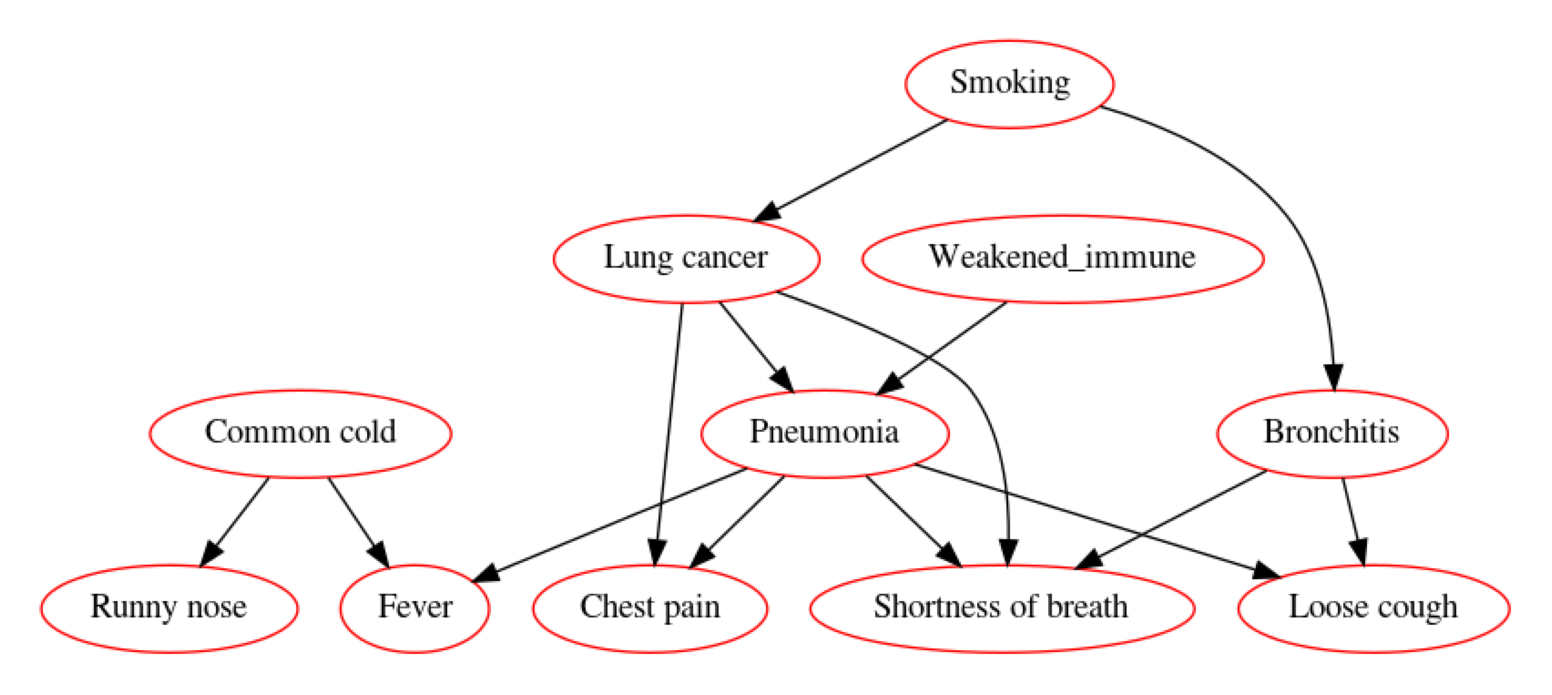

In [82]:
import pygraphviz
# We sketch a dummy model only to see the graph
sketch_model = BayesianNetwork("Medical Report - sketch")

# Topology expressed with edges 
edges = []
for variable_name, parents in ordered_parents.items():
    for parent in parents:
        edge = [parent, variable_name]
        edges.append(edge)
        
# Dummy variables
nodes = {}
for variable_name in statistics.keys():
    distribution = DiscreteDistribution({'Y': .5, 'N': .5})
    node = Node(distribution, name=variable_name)
    nodes[variable_name] = node
    
# Add States    
sketch_model.add_states(*nodes.values())

# Add Edges
for edge in edges:
    sketch_model.add_edge(nodes[edge[0]], nodes[edge[1]])
    
# Plot
figure(dpi=160)
sketch_model.plot()

## Belief propagation

In [83]:
# Let us initialize the real model
model = BayesianNetwork("Medical Report")

# Topology expressed as list of children
ordered_children = {variable: [] for variable in statistics.keys()}
for edge in edges:
    ordered_children[edge[0]].append(edge[1])

# Independent variables and leaves
independent_variables = [variable for variable, parents in ordered_parents.items() if not parents]
leaves = [variable for variable, children in ordered_children.items() if not children]
# Write a function that lists the variables in stages so that the dependencies of a variable 
# are always coming from a previous stage  
def propagate_net(independent_variables,leaves,ordered_parents):
    belief_propagation = []
    processed = []

    belief_propagation.append(independent_variables)
    processed.extend(independent_variables)
    
    while True:
        tempStage = []
        for var in ordered_parents:
            if var not in processed:
                if all(elem in processed for elem in ordered_parents[var]):
                    tempStage.append(var)
                    
        belief_propagation.append(tempStage)
        processed.extend(tempStage)
        if all(elem in processed for elem in leaves):
            break

    return belief_propagation

# Check the previous graph to see how at every stage, all the parents are already known
belief_propagation = propagate_net(independent_variables,leaves,ordered_parents)
for stage, variables in enumerate(belief_propagation):
    print(f' {stage+1}) {", ".join(variables)}')

 1) Weakened_immune, Smoking, Common cold
 2) Lung cancer, Bronchitis, Runny nose
 3) Pneumonia
 4) Fever, Loose cough, Chest pain, Shortness of breath


## Independent variables

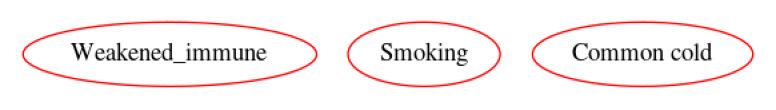

In [84]:
# We add variables following the order above
distributions = {}
nodes = {}
for variable_name in independent_variables:
    probability = statistics[variable_name]
    distribution = DiscreteDistribution({'Y': probability, 'N': 1 - probability})
    node = Node(distribution, name=variable_name)
    distributions[variable_name] = distribution
    nodes[variable_name] = node
    
model.add_states(*nodes.values())
figure(dpi=80)
model.plot()

args = [statistics,ordered_conditionals,ordered_parents,distributions,nodes,model]

## Infer the conditional probabilities

In [85]:
belief_propagation = propagate_net(independent_variables,leaves,ordered_parents)
for i in belief_propagation:
    print(i)

['Weakened_immune', 'Smoking', 'Common cold']
['Lung cancer', 'Bronchitis', 'Runny nose']
['Pneumonia']
['Fever', 'Loose cough', 'Chest pain', 'Shortness of breath']


Weakened_immune: 
	 Inferred probability = 0.370
	 Statistic = 0.053
Smoking: 
	 Inferred probability = 0.370
	 Statistic = 0.29
Common cold: 
	 Inferred probability = 0.370
	 Statistic = 0.37
Lung cancer: 
	 Inferred probability = 0.100
	 Statistic = 0.037
Bronchitis: 
	 Inferred probability = 0.094
	 Statistic = 0.09
Runny nose: 
	 Inferred probability = 0.358
	 Statistic = None
Pneumonia: 
	 Inferred probability = 0.022
	 Statistic = 0.018
Fever: 
	 Inferred probability = 0.093
	 Statistic = 0.085
Loose cough: 
	 Inferred probability = 0.191
	 Statistic = 0.19
Chest pain: 
	 Inferred probability = 0.196
	 Statistic = 0.14
Shortness of breath: 
	 Inferred probability = 0.209
	 Statistic = 0.18


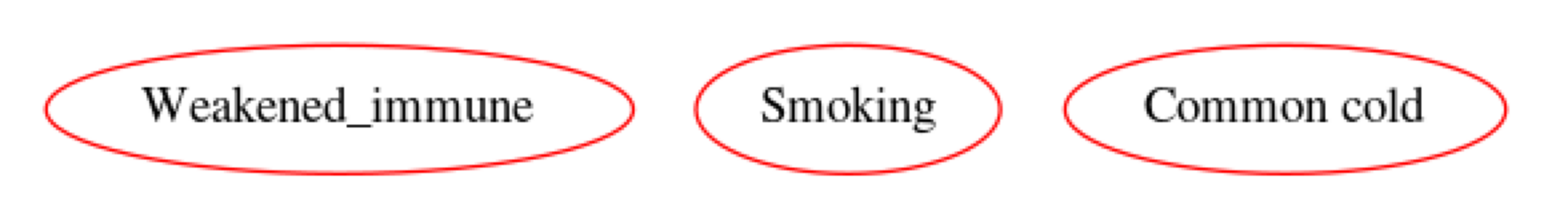

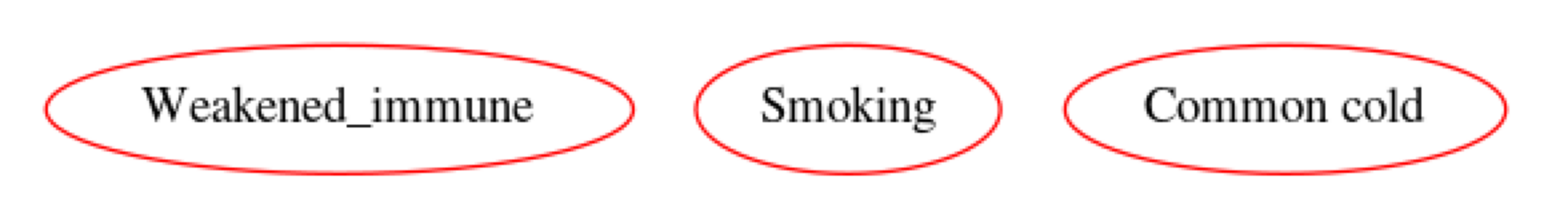

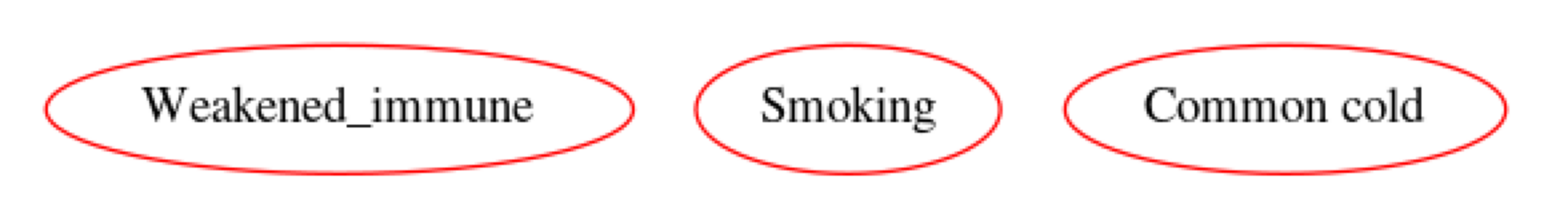

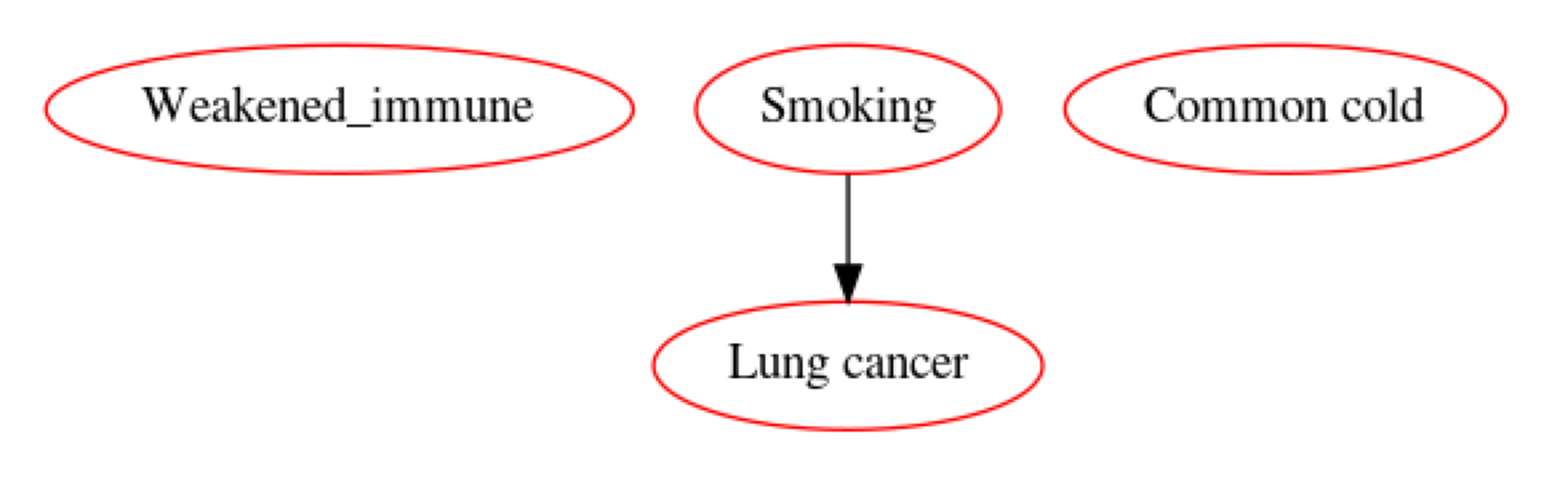

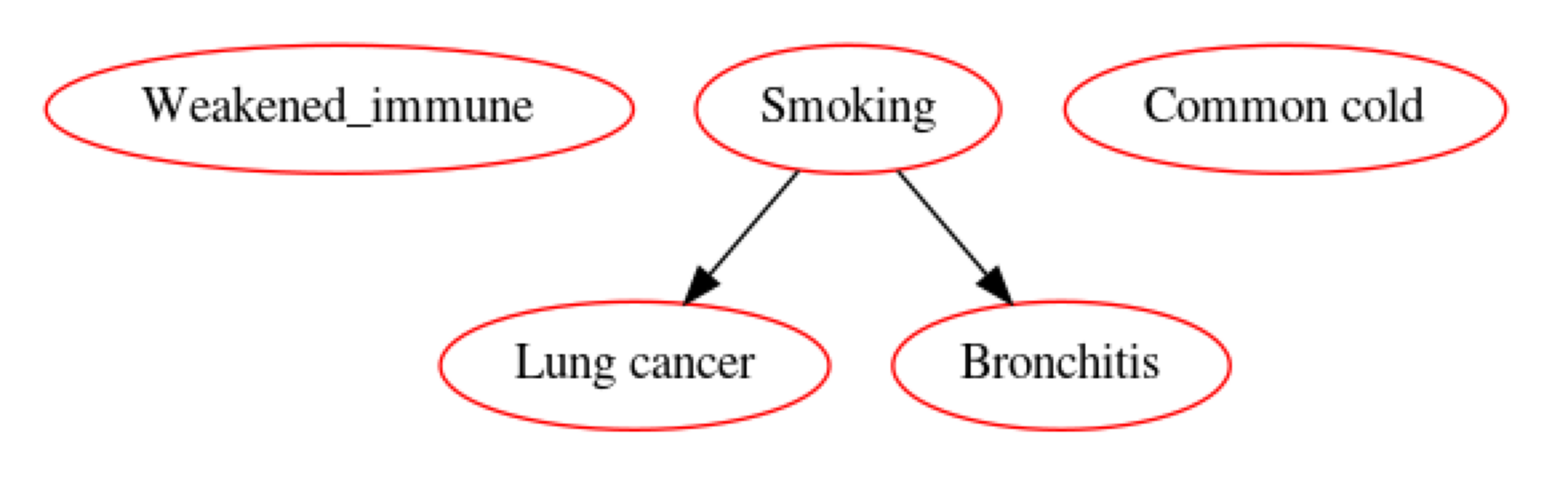

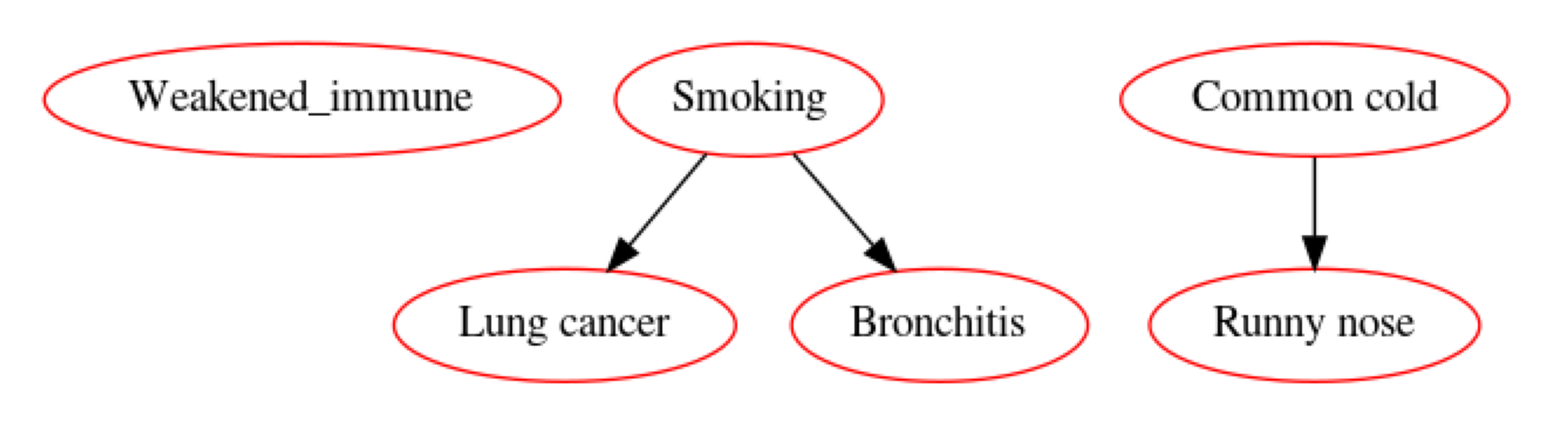

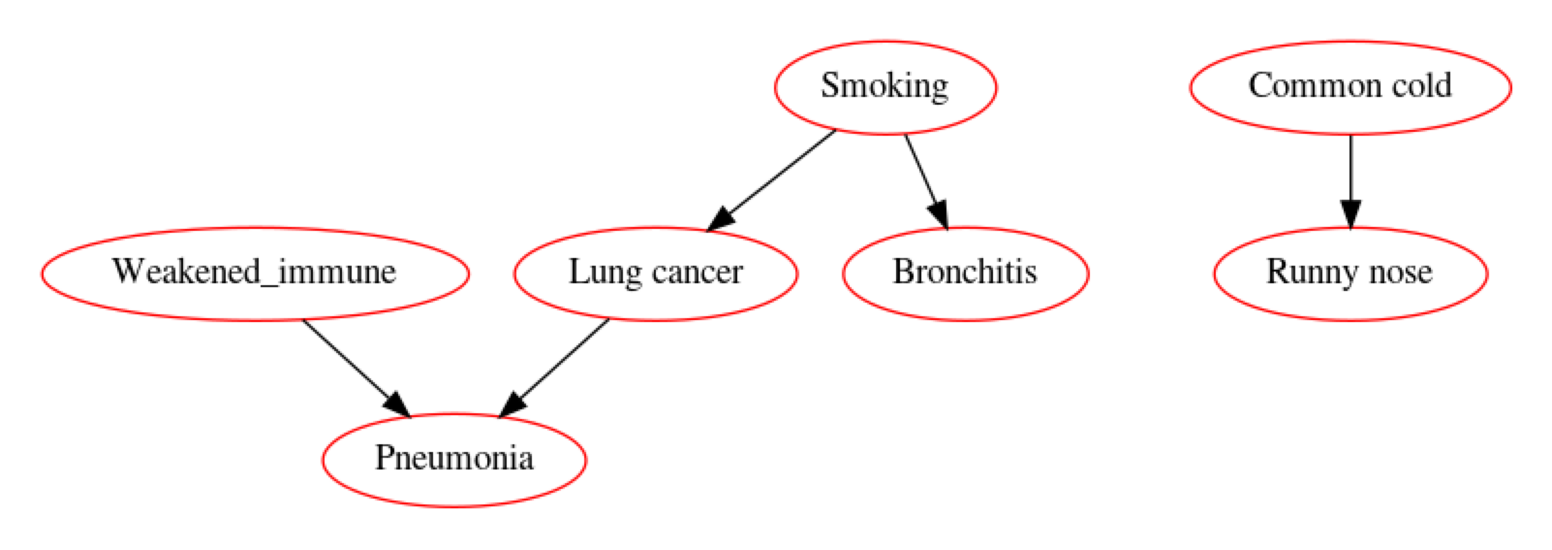

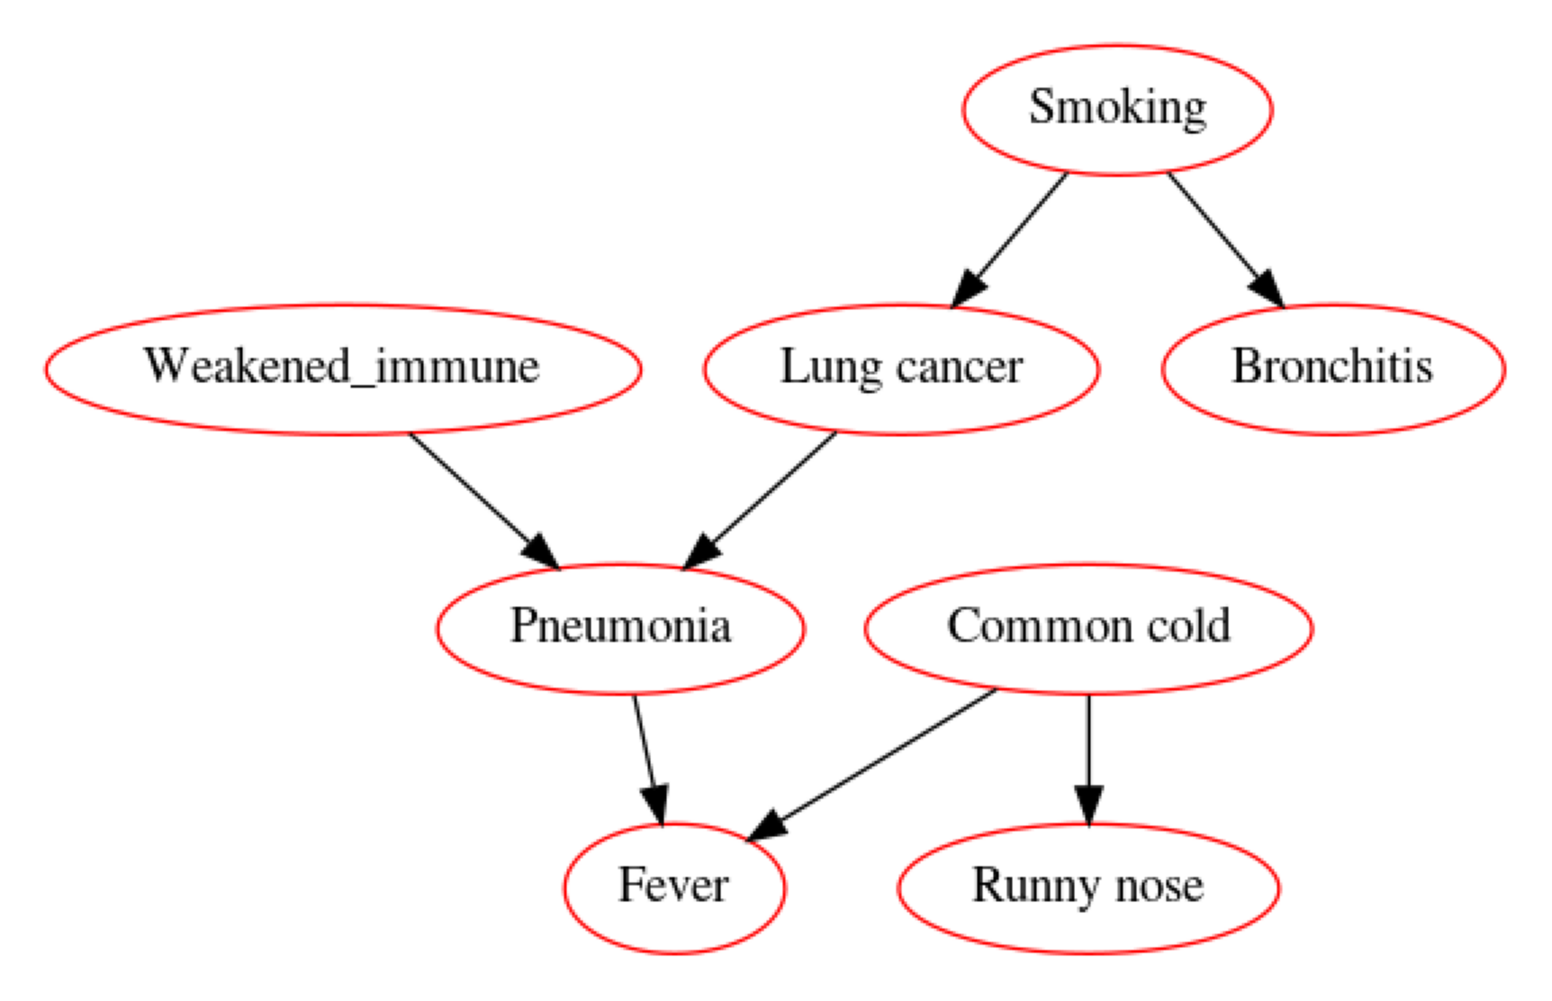

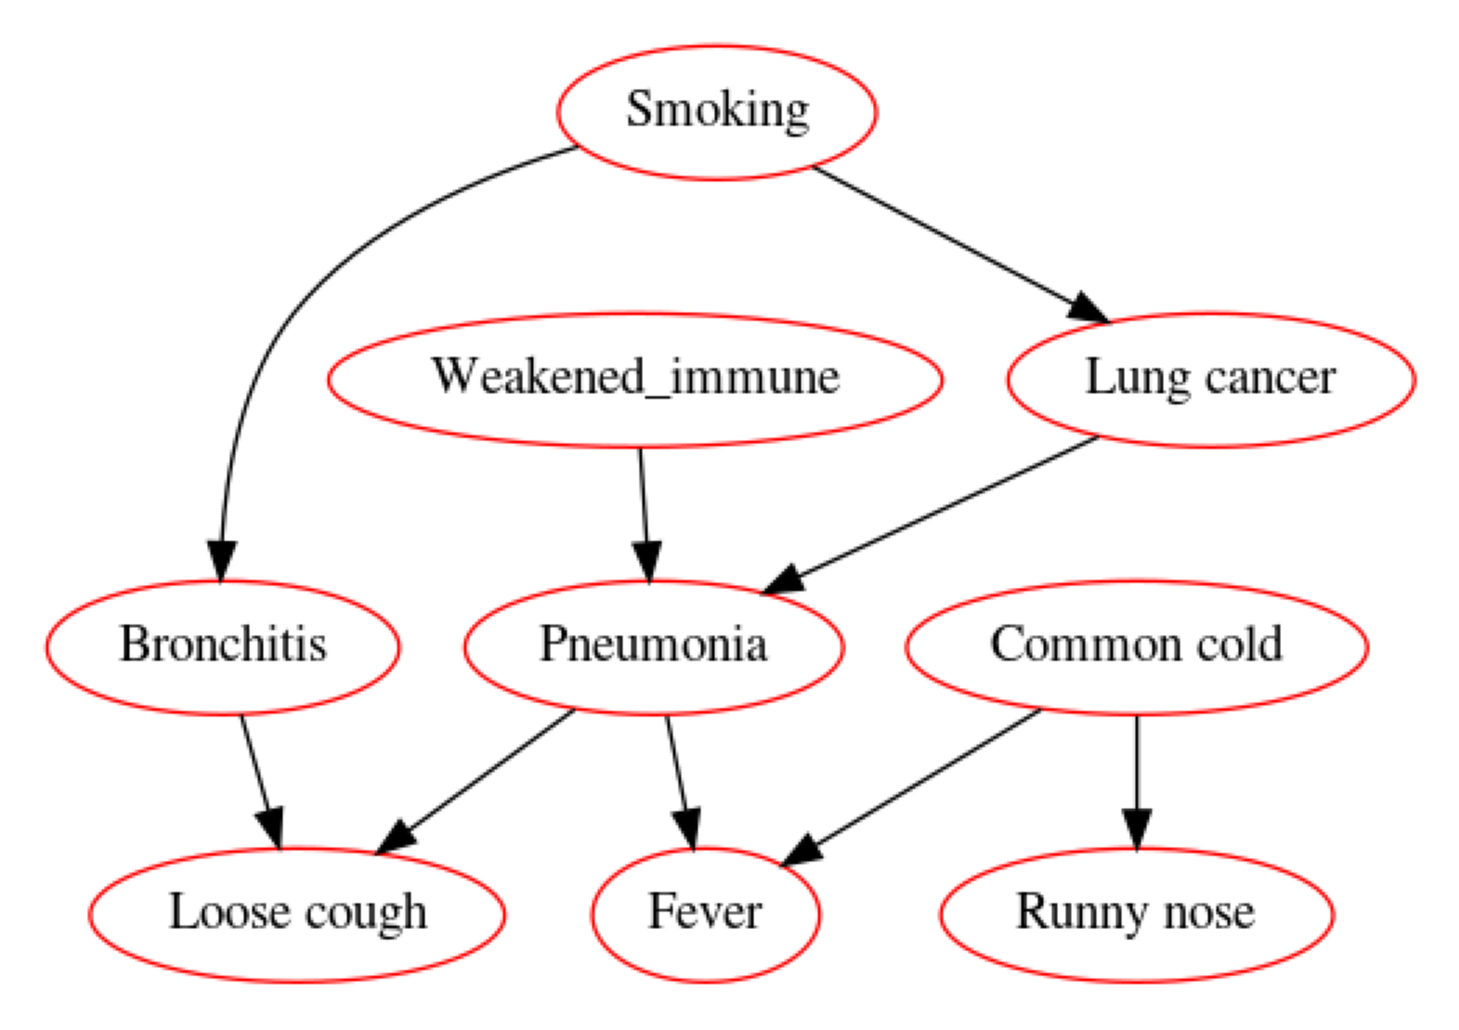

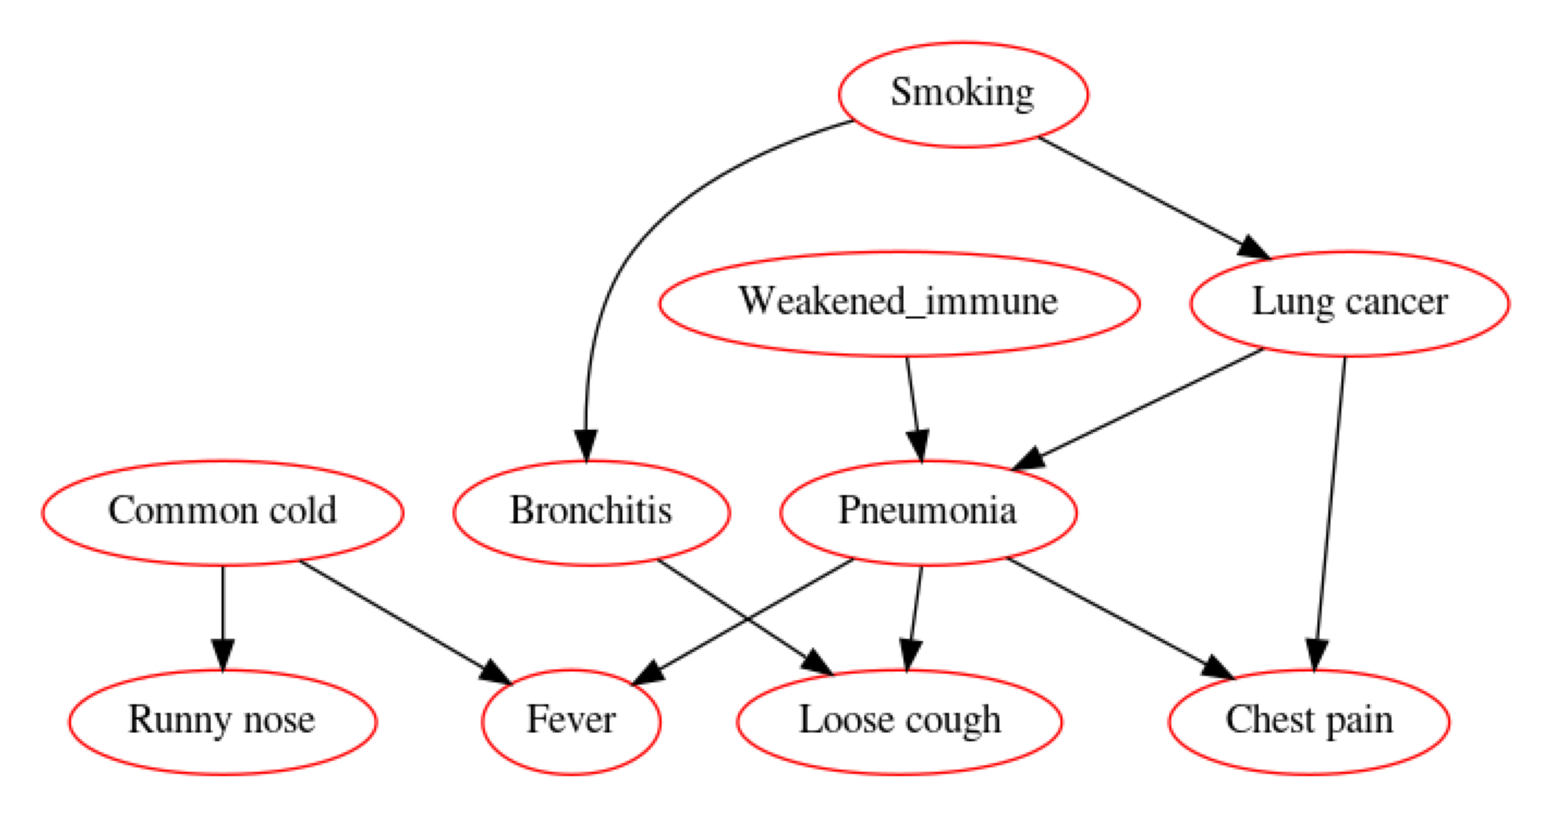

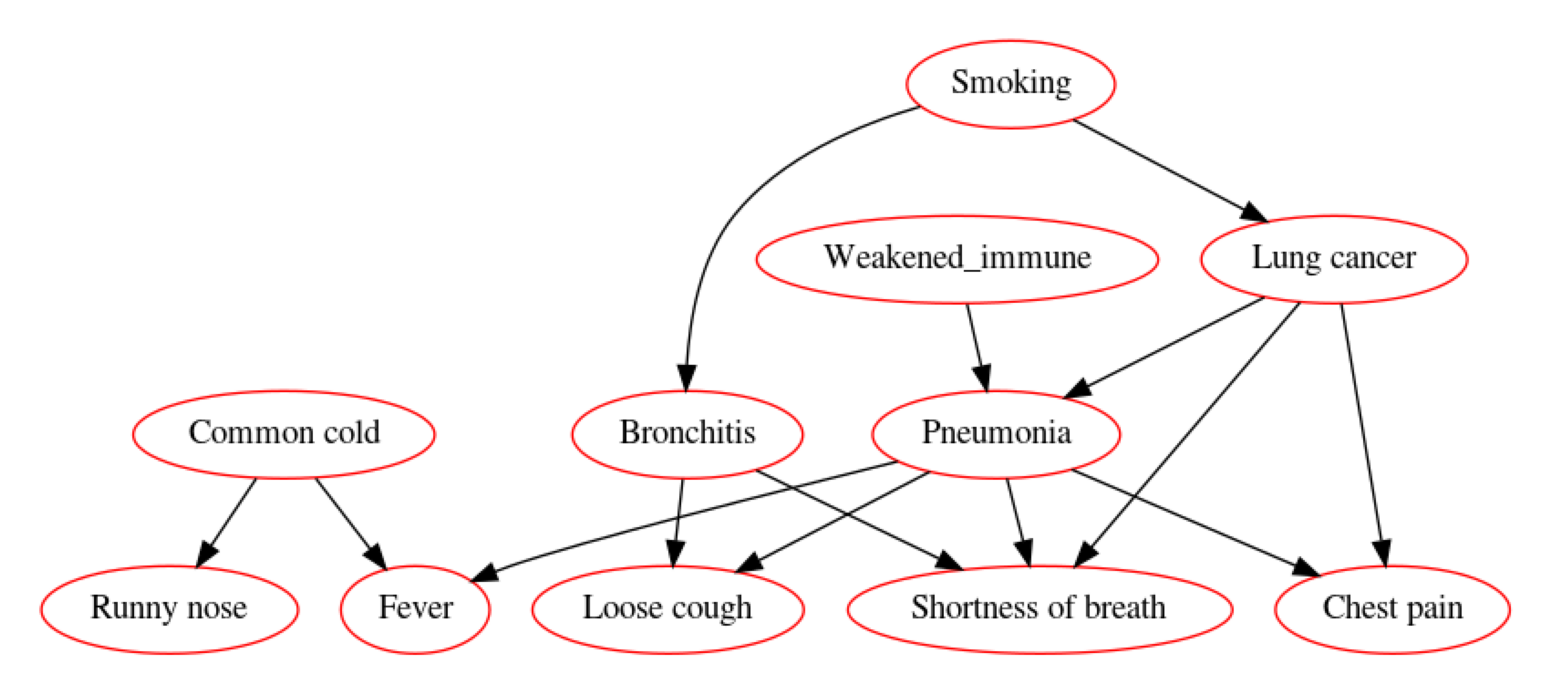

In [86]:
# We add the variable to the model and check that the statistics are consistent
belief_propagation = propagate_net(independent_variables,leaves,ordered_parents)
for stage in belief_propagation:
    for var in stage:
        add_conditional_variable(var,*args,plot=True)
        
#add_conditional_variable('Lung cancer',*args,plot=True)

# If you are using colab you can use tabs to add sequentially more variables 

# from google.colab import widgets
# tab_variables = ['example2']
# tb = widgets.TabBar([str(i) for i in range(len(tab_variables))])
# for i, variable_name in enumerate(tab_variables):
#   with tb.output_to(i, select=(i < 1)):
#     add_conditional_variable(variable_name,*args)


In [100]:
# To make the code more readable you can name the indices of the variables
node_list = list(nodes.keys())
Fever_index = node_list.index('Fever')
Runny_nose_index = node_list.index('Runny nose')
Chest_pain_index = node_list.index('Chest pain') 
Loose_cough_index = node_list.index('Loose cough') 
Shortness_breath_index = node_list.index('Shortness of breath')
Weakened_immune_index = node_list.index('Weakened_immune')
Bronchitis_index = node_list.index('Bronchitis')
Lung_cancer_index = node_list.index('Lung cancer')
Smoking_index = node_list.index('Smoking')


Effect_index = node_list.index('Common cold')


## Cause -> Effect
### Question 5:
P(Cause = 'Pneumonia'| Effect = 'No runny nose', 'fever)


In [93]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Fever_index] = 'Y'
obs_states[Runny_nose_index] = 'N'


# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Pneumonia')   

When C = No_Runny nose, Fever:
Prob(Pneumonia|C): 0.756



### Question 6:
P(Cause = 'Lung cancer'| Effect = 'Chest pain', 'shortness of breath','no fever', 'no loose cough' )

In [102]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Chest_pain_index] = 'Y'
obs_states[Shortness_breath_index] = 'Y'
obs_states[Fever_index] = 'N'
obs_states[Loose_cough_index] = 'N'


# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Lung cancer')   

When C = No_Fever, No_Loose cough, Chest pain, Shortness of breath:
Prob(Lung cancer|C): 0.814



### Question 7:
P(Cause = 'Lung cancer'| Effect = 'Chest pain', 'shortness of breath','no fever', 'no loose cough' )

In [101]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
#obs_states[Bronchitis_index] = 'Y'
obs_states[Lung_cancer_index] = 'Y'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Bronchitis') 

obs_states = [None]*len(node_list)
obs_states[Bronchitis_index] = 'Y'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Lung cancer') 

obs_states = [None]*len(node_list)
obs_states[Lung_cancer_index] = 'Y'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target='Smoking') 

When C = Lung cancer:
Prob(Bronchitis|C): 0.094

When C = Bronchitis:
Prob(Lung cancer|C): 0.100

When C = Lung cancer:
Prob(Smoking|C): 0.290



Possible explanation is that there is a high propability that people who have lung cancer have smoked, which is also a cause for bronchitis

### Question 8:
P(Cause = '?'| Effect = 'Fever', 'Loose cough', 'No smoking', 'no Runny nose' )

In [107]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Fever_index] = 'Y'
obs_states[Loose_cough_index] = 'Y'
obs_states[Smoking_index] = 'N'
obs_states[Runny_nose_index] = 'N'


# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target=None)   

When C = No_Smoking, No_Runny nose, Fever, Loose cough:
Prob(Weakened_immune|C): 0.716
Prob(Common cold|C): 0.060
Prob(Lung cancer|C): 0.293
Prob(Bronchitis|C): 0.013
Prob(Pneumonia|C): 0.963
Prob(Chest pain|C): 0.879
Prob(Shortness of breath|C): 0.493



High chance of Pneumonia, we should investigate if he has chest pain and shortness of breath, if these two are are present it is almost certain that it's a case of pneumonia

In [109]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Fever_index] = 'Y'
obs_states[Loose_cough_index] = 'Y'
obs_states[Smoking_index] = 'N'
obs_states[Runny_nose_index] = 'N'

#if these one are investigated
obs_states[Chest_pain_index] = 'Y'
obs_states[Shortness_breath_index] = 'Y'


# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target=None)   

When C = No_Smoking, No_Runny nose, Fever, Loose cough, Chest pain, Shortness of breath:
Prob(Weakened_immune|C): 0.733
Prob(Common cold|C): 0.035
Prob(Lung cancer|C): 0.305
Prob(Bronchitis|C): 0.017
Prob(Pneumonia|C): 0.993



### Question 9:
P(Cause = '?'| Effect = 'Smoker', 'Shortness of breath', 'Weakened immune' )

In [115]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Weakened_immune_index] = 'Y'
obs_states[Smoking_index] = 'Y'
obs_states[Shortness_breath_index] = 'Y'

obs_states[Chest_pain_index] = 'N'
obs_states[Fever_index] = 'N'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target=None)   

When C = Weakened_immune, Smoking, No_Fever, No_Chest pain, Shortness of breath:
Prob(Common cold|C): 0.320
Prob(Lung cancer|C): 0.023
Prob(Bronchitis|C): 0.764
Prob(Runny nose|C): 0.311
Prob(Pneumonia|C): 0.006
Prob(Loose cough|C): 0.712



We will need proof of fever and chest pain if these are both absent we have a high certainty that it's bronchitis

In [116]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Weakened_immune_index] = 'Y'
obs_states[Smoking_index] = 'Y'
obs_states[Shortness_breath_index] = 'Y'

obs_states[Chest_pain_index] = 'N'
obs_states[Fever_index] = 'N'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target=None)   

When C = Weakened_immune, Smoking, No_Fever, No_Chest pain, Shortness of breath:
Prob(Common cold|C): 0.320
Prob(Lung cancer|C): 0.023
Prob(Bronchitis|C): 0.764
Prob(Runny nose|C): 0.311
Prob(Pneumonia|C): 0.006
Prob(Loose cough|C): 0.712



if they are present it will be almost always be pneumonia

In [117]:
# We create a vector of known and unknown states 
obs_states = [None]*len(node_list)
obs_states[Weakened_immune_index] = 'Y'
obs_states[Smoking_index] = 'Y'
obs_states[Shortness_breath_index] = 'Y'

obs_states[Chest_pain_index] = 'Y'
obs_states[Fever_index] = 'Y'

# We calculate the inferenced probabilities 
# (None target lists the probabilities of all the non observed variable)
print_predict_proba(model, nodes, obs_states, target=None)   

When C = Weakened_immune, Smoking, Fever, Chest pain, Shortness of breath:
Prob(Common cold|C): 0.386
Prob(Lung cancer|C): 0.121
Prob(Bronchitis|C): 0.413
Prob(Runny nose|C): 0.373
Prob(Pneumonia|C): 0.978
Prob(Loose cough|C): 0.890

